### TESS light curve filtering


In [1]:
pip install batman-package

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install astroquery ldtk==1.7

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install emcee corner pygtc

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import pickle
%matplotlib widget
import pickle 

In [3]:
from wotan import flatten 

In [15]:
print(astropy.__version__)

6.0.1


In [16]:
# -- TASTE data --
# Loading previously saved arrays with time (BJD_TDB) and flux (normalized and non-normalized).
# 'pickle.load()' loads python objects from the specified file.
taste_bjd_tdb = pickle.load(open('taste_bjdtdb.p','rb'))

differential_allref_normalized = pickle.load(open('differential_allref_normalized.p','rb'))
differential_allref_normalized_error = pickle.load(open('differential_allref_normalized_error.p','rb'))

differential_allref = pickle.load(open('differential_allref.p','rb'))
differential_allref_error = pickle.load(open('differential_allref_error.p','rb'))



# -- TESS data --
# Loading one sector's data for the same star, already filtered to remove bad data points.
# тут наш файл для нашей планеты
tess_sector23_dict = pickle.load(open('/Users/alina.zakareeva/Desktop/Lab 2/notebook_TESS/HATP12_TESS_sector23_filtered.p', 'rb'))
tess_bjd_tdb = tess_sector23_dict['time']
tess_normalized_flux = tess_sector23_dict['selected_flux']
tess_normalized_ferr = tess_sector23_dict['selected_flux_error']



In [17]:
import batman
import numpy as np
import matplotlib.pyplot as plt

For better results, please use the values reported in Planet Parameters: TOIs (TESS Project) 

For each parameter, I reported the name used in the ExoFOP table between parenthesis
* params.t0 : time of inferior conjunction (Epoch)
* params.per: orbital period of the planet, in days (Period)
* params.rp: scaled planetary radius, i.e., planet radius in units of stellar radii (Rad_p/Rad_s)
* params.a: scaled semi-major axis, i.e., semi-major axis in units of stellar radii (a/Rad_s)
* params.inc: orbital inclination in degrees (Inclination)

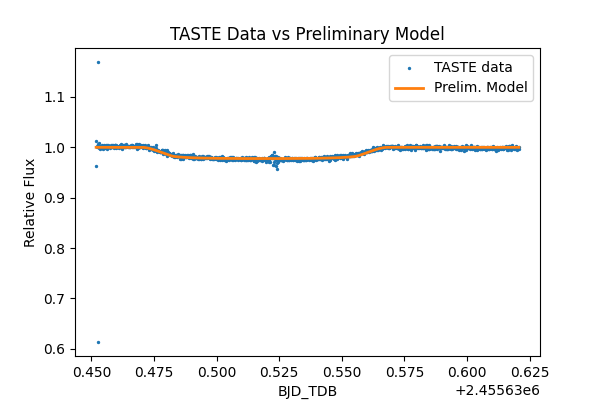

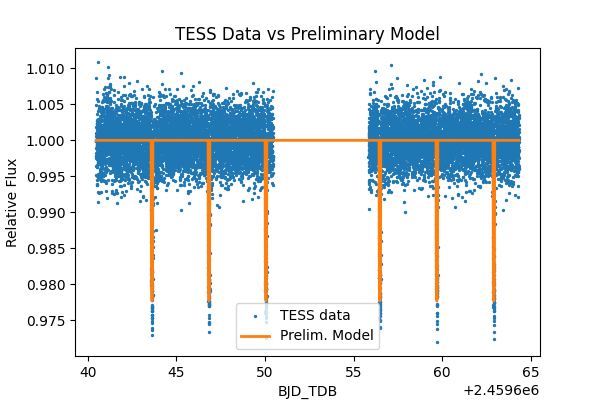

In [18]:
# Our parameters are here https://exofop.ipac.caltech.edu/tess/
# Initialize transit parameters
params = batman.TransitParams()
params.t0 = 2459685.398095           # time of inferior conjunction 2459685.398095 BJD
params.per = 3.2130578               # orbital period 3.2130578 d 
params.rp = 0.1406                   # planet radius (in units of stellar radii) 0.1406 
params.a = 11.77                     # semi-major axis (in units of stellar radii) 11.77
params.inc = 89.0                    # orbital inclination (in degrees) 89
params.ecc = 0.0                     # eccentricity
params.w = 90.0                      # longitude of periastron (in degrees)
params.u = [0.1, 0.5]                # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       # limb darkening model


# --- Model vs TASTE data (preliminary) ---
m_taste = batman.TransitModel(params, taste_bjd_tdb)
taste_model_flux = m_taste.light_curve(params)

plt.figure(figsize=(6, 4))
plt.title("TASTE Data vs Preliminary Model")
plt.scatter(taste_bjd_tdb, differential_allref_normalized, s=2, label='TASTE data')
plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1', label='Prelim. Model')
plt.xlabel("BJD_TDB")
plt.ylabel("Relative Flux")
plt.legend()
plt.show()


# --- Model vs TESS data (preliminary) ---
m_tess = batman.TransitModel(params, tess_bjd_tdb)
tess_model_flux = m_tess.light_curve(params)

plt.figure(figsize=(6, 4))
plt.title("TESS Data vs Preliminary Model")
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2, label='TESS data')
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1', label='Prelim. Model')
plt.xlabel("BJD_TDB")
plt.ylabel("Relative Flux")
plt.legend()
plt.show()

# we are going to use https://github.com/hpparvi/ldtk 

Python Limb Darkening Toolkit (ldtk, Parviainen & Aigrain 2015, GitHub page), 

a Python toolkit for calculating stellar limb darkening coefficients for arbitrary passbands using the stellar spectrum model library by Husser et al. (2013). 

This tool provides access to the Spanish [Virtual Observatory (SVO) Filter Profile Service (FPS)](http://svo2.cab.inta-csic.es/theory/fps/). to retrieve the passband of the filters used to gather our data, thus further facilitating our job. 

The class uses astroquery to download the data, which naturally requires an internet connection.

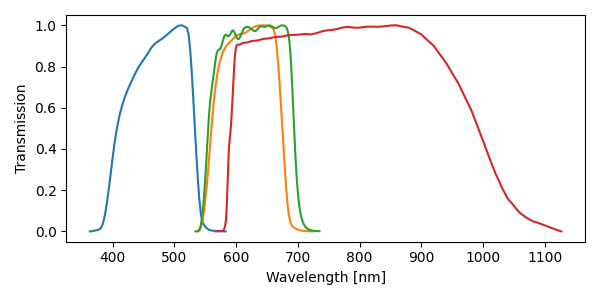

In [19]:
# Check which filter was used to gather the TASTE data, 
# different datasets may have been gathered with different filters

from ldtk import SVOFilter, LDPSetCreator
SVOFilter.shortcuts


sloan_g = SVOFilter('SLOAN/SDSS.g')
sloan_r = SVOFilter('SLOAN/SDSS.r')
sloan_rprime = SVOFilter('SLOAN/SDSS.rprime_filter')
tess_fr = SVOFilter('TESS')

fig, ax = plt.subplots(figsize=(6,3))
sloan_g.plot(ax=ax)
sloan_r.plot(ax=ax)
sloan_rprime.plot(ax=ax)
tess_fr.plot(ax=ax)
fig.tight_layout()
plt.show()

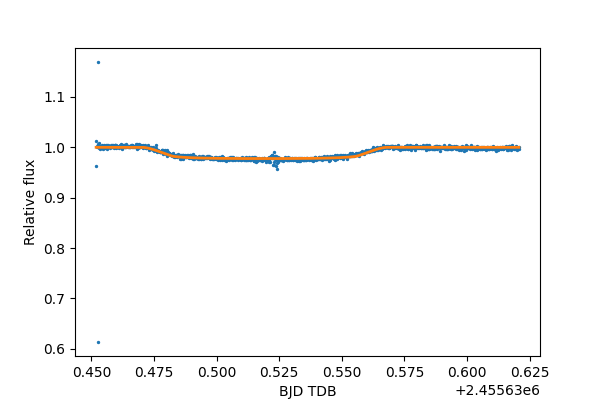

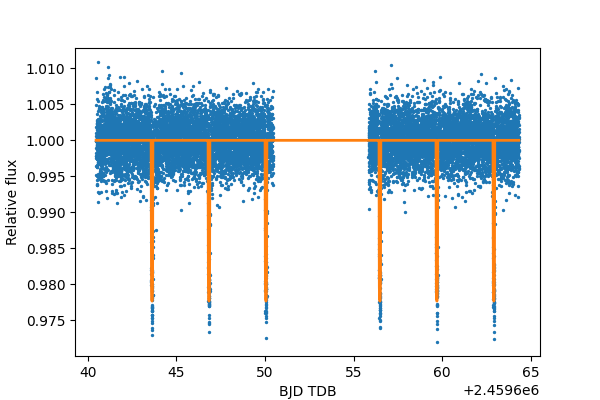

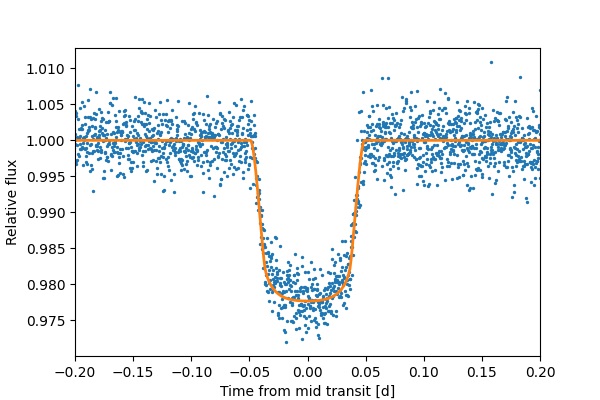

[0.96249238 1.0122846  1.00226401 ... 0.99831779 1.00001233 0.99716387]


In [20]:
params = batman.TransitParams()
params.t0 = 2459685.398095           # time of inferior conjunction 2459685.398095 BJD
params.per = 3.2130578               # orbital period 3.2130578 d 
params.rp = 0.1406                   # planet radius (in units of stellar radii) 0.1406 
params.a = 11.77                     # semi-major axis (in units of stellar radii) 11.77
params.inc = 89.0                    # orbital inclination (in degrees) 89
params.ecc = 0.0                     # eccentricity
params.w = 90.0                      # longitude of periastron (in degrees)
params.u = [0.1, 0.5]                # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       # limb darkening model

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_model_flux = m_taste.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_allref_normalized, s=2)

plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()


m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_model_flux =m_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid transit [d]")
plt.ylabel("Relative flux")
plt.show()

print(differential_allref_normalized)

In [22]:
# Stellar parameters from the literature (or ExoFOP):
# (value, uncertainty)
teff = (4652.87, 115.904)   # Effective temperature
logg = (4.61265, 0.08)  # Log g
z = (0.20, 0.10)     # Metallicity [Fe/H]

# Initialize the LDPSetCreator with these parameters and relevant filters
filters = [sloan_r, tess_fr]
sc = LDPSetCreator(teff=teff, logg=logg, z=z, filters=filters)

# Create the limb darkening profiles using 2000 samples
ps = sc.create_profiles(nsamples=2000)

# Resample the profiles and artificially inflate uncertainties (optional)
ps.resample_linear_z(100)
ps.set_uncertainty_multiplier(10)

# Compute the 'quadratic' limb darkening coefficients in the q1, q2 formalism
qm, qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)
chains = np.array(ps._samples['qd'])  # The raw MCMC chains for q1, q2

# Extract the coefficients for each filter (Sloan r is index 0, TESS is index 1).
u1_sloan_r_chains = chains[0, :, 0]
u2_sloan_r_chains = chains[0, :, 1]
u1_tess_chains    = chains[1, :, 0]
u2_tess_chains    = chains[1, :, 1]

print('Sloan r LD coefficients:',
      'u1 = {0:.2f} ± {1:.2f}'.format(np.mean(u1_sloan_r_chains), np.std(u1_sloan_r_chains)),
      'u2 = {0:.2f} ± {1:.2f}'.format(np.mean(u2_sloan_r_chains), np.std(u2_sloan_r_chains)))
print('TESS LD coefficients:',
      'u1 = {0:.2f} ± {1:.2f}'.format(np.mean(u1_tess_chains), np.std(u1_tess_chains)),
      'u2 = {0:.2f} ± {1:.2f}'.format(np.mean(u2_tess_chains), np.std(u2_tess_chains)))

# Choose final LD coefficients (for instance, from the MCMC means) with some rounding
u1_sloan_r = 0.65
u2_sloan_r = 0.08
u1_tess    = 0.51
u2_tess    = 0.10


Updating server file list:   0%|          | 0/9 [00:00<?, ?it/s]

Need to download 69 files, approximately 23.05 MB


LDTk downloading uncached files:   0%|          | 0/69 [00:00<?, ?it/s]

Sloan r LD coefficients: u1 = 0.70 ± 0.02 u2 = 0.05 ± 0.06
TESS LD coefficients: u1 = 0.55 ± 0.02 u2 = 0.09 ± 0.04


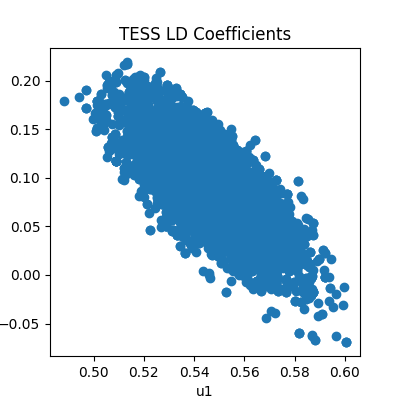

In [23]:
plt.figure(figsize=(4,4))
plt.title('TESS LD Coefficients')
plt.xlabel('u1')
plt.ylabel('u2')
plt.scatter(u1_tess_chains, u2_tess_chains)
plt.show()

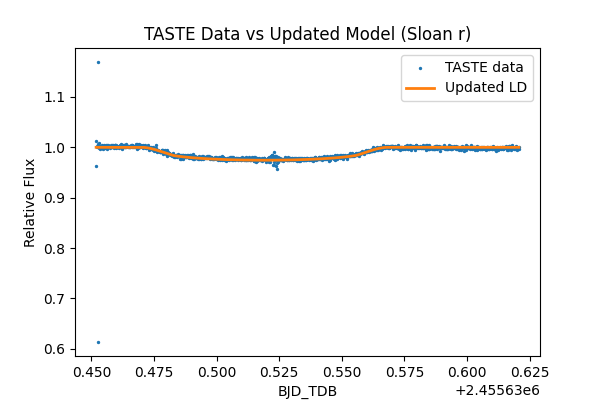

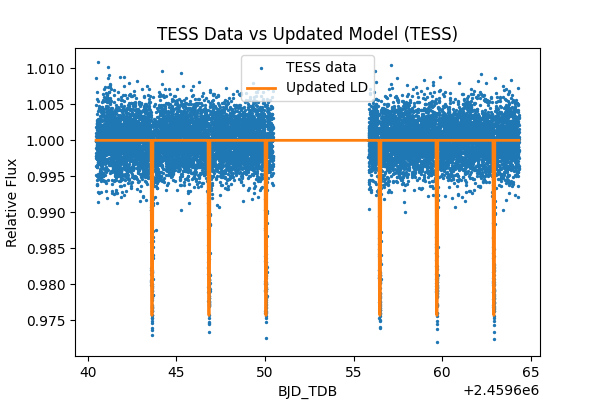

In [24]:
u1_sloan_r = 0.70
u2_sloan_r = 0.05
u1_tess    = 0.55
u2_tess    = 0.09
# Sloan r LD coefficients: u1 = 0.70 ± 0.02 u2 = 0.05 ± 0.06
# TESS LD coefficients: u1 = 0.55 ± 0.02 u2 = 0.09 ± 0.04

# Re-create the transit parameters
params = batman.TransitParams()
params.t0 = 2459685.398095           # time of inferior conjunction 2459685.398095 BJD
params.per = 3.2130578               # orbital period 3.2130578 d 
params.rp = 0.1406                   # planet radius (in units of stellar radii) 0.1406 
params.a = 11.77                     # semi-major axis (in units of stellar radii) 11.77
params.inc = 89.0                    # orbital inclination (in degrees) 89
params.ecc = 0.0                     # eccentricity
params.w = 90.0                      # longitude of periastron (in degrees)
params.u = [0.1, 0.5]                # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       # limb darkening model

# -- Compare the updated model to TASTE data (Sloan r band) --
params.u = [u1_sloan_r, u2_sloan_r]
m_taste = batman.TransitModel(params, taste_bjd_tdb)
taste_model_flux = m_taste.light_curve(params)

plt.figure(figsize=(6, 4))
plt.title("TASTE Data vs Updated Model (Sloan r)")
plt.scatter(taste_bjd_tdb, differential_allref_normalized, s=2, label='TASTE data')
plt.plot(taste_bjd_tdb, taste_model_flux, lw=2, c='C1', label='Updated LD')
plt.xlabel("BJD_TDB")
plt.ylabel("Relative Flux")
plt.legend()
plt.show()

# -- Compare the updated model to TESS data --
params.u = [u1_tess, u2_tess]
m_tess = batman.TransitModel(params, tess_bjd_tdb)
tess_model_flux = m_tess.light_curve(params)

plt.figure(figsize=(6, 4))
plt.title("TESS Data vs Updated Model (TESS)")
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2, label='TESS data')
plt.plot(tess_bjd_tdb, tess_model_flux, lw=2, c='C1', label='Updated LD')
plt.xlabel("BJD_TDB")
plt.ylabel("Relative Flux")
plt.legend()
plt.show()

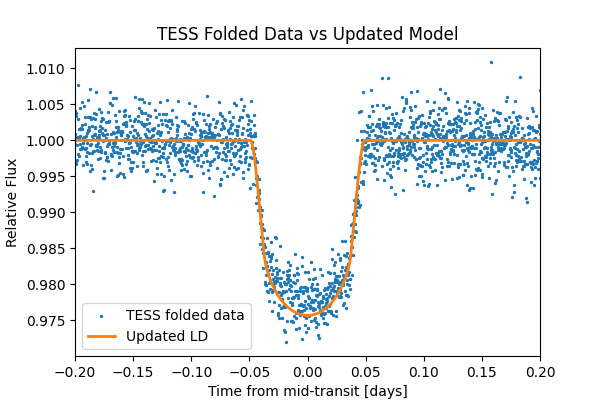

In [25]:
# -- Create a phase-folded plot for the TESS data --
folded_tess_time = (tess_bjd_tdb - params.t0 - params.per / 2.) % params.per - params.per / 2.
folded_range = np.arange(-params.per / 2., params.per / 2., 0.001)

# For plotting the folded model, we often set t0=0 in a new params object
params_folded = batman.TransitParams()
params_folded.t0  = 0.0
params_folded.per = params.per
params_folded.rp  = params.rp
params_folded.a   = params.a
params_folded.inc = params.inc
params_folded.ecc = params.ecc
params_folded.w   = params.w
params_folded.u   = params.u  # use TESS LD
params_folded.limb_dark = params.limb_dark

m_folded_tess = batman.TransitModel(params_folded, folded_range)
tess_folded_flux = m_folded_tess.light_curve(params_folded)

plt.figure(figsize=(6, 4))
plt.title("TESS Folded Data vs Updated Model")
plt.scatter(folded_tess_time, tess_normalized_flux, s=2, label='TESS folded data')
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1', label='Updated LD')
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative Flux")
plt.legend()
plt.show()